# Predicting the MVP of a NBA season

In [101]:
#Import Libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import top_k_accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Data engineering

In [102]:
#Declaration of the dataset containing the inputs
try:
    df = pd.read_csv(r"C:\Users\touze\Desktop\ml project - NBA MVP predictor\Data sets\DFtraining.csv", 
                     sep=';', 
                     low_memory=False)
    
# Identify the probelmatic column
    print(f"Column 49 : {df.columns[49]}")
    print(f"Unic types in column 49: {df.iloc[:, 49].apply(type).unique()}")

except Exception as e:
    print(f"Erreur : {e}")

Column 49 : Wins_Vs_League_Avg
Unic types in column 49: [<class 'str'>]


In [103]:
#Data Analysis : float conversion + Nan filling

df['Wins_Vs_League_Avg'] = pd.to_numeric(df['Wins_Vs_League_Avg'], errors='coerce')


print(f"Type after conversion: {df['Wins_Vs_League_Avg'].dtype}")
print(f"Missing values created: {df['Wins_Vs_League_Avg'].isna().sum()}")

Type after conversion: float64
Missing values created: 418


In [104]:
#Inspection of the input dataset

print("Dataset structure:")
print(f"Shape : {df.shape}")
print("      ")
print(f"Data types:")
print(df.dtypes.value_counts())

Dataset structure:
Shape : (11000, 83)
      
Data types:
int64      41
object     36
bool        5
float64     1
Name: count, dtype: int64


In [105]:
#Seconde analysis, more detailed

print("Data Types detail:")



print(f" Columns int64 ({len(df.select_dtypes(include=['int64']).columns)}): Numeric")
print(f" Columns float64 ({len(df.select_dtypes(include=['float64']).columns)}): Numeric")

bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
print(f" Columns bool ({len(bool_cols)}): {bool_cols}")


object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\n Colonnes object ({len(object_cols)}): {object_cols}")

Data Types detail:
 Columns int64 (41): Numeric
 Columns float64 (1): Numeric
 Columns bool (5): ['Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG', 'Conference_West']

 Colonnes object (36): ['Player', 'Pos', 'Team', 'Per', 'Ts%', '3Par', 'Ftr', 'Trb%', 'Ast%', 'Stl%', 'Blk%', 'Tov%', 'Usg%', 'Ows', 'Dws', 'Ws', 'Ws/48', 'Obpm', 'Dbpm', 'Bpm', 'Ft%', 'Weight', 'Conference', 'mvp_score', 'team_success_factor', 'usage_efficiency', 'scoring_load', 'per_vs_league', 'vorp_vs_league', 'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg', 'games_played_pct']


In [106]:
#NBA Stats columns (should be numeric)
numeric_candidates = [
    'Per', 'Ts%', '3Par', 'Ftr', 'Trb%', 'Ast%', 'Stl%', 'Blk%', 'Tov%', 'Usg%',
    'Ows', 'Dws', 'Ws', 'Ws/48', 'Obpm', 'Dbpm', 'Bpm', 'Ft%', 'Weight',
    'mvp_score', 'team_success_factor', 'usage_efficiency', 'scoring_load',
    'per_vs_league', 'vorp_vs_league', 'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg', 'games_played_pct'
]

#Columns that should be textual
text_columns = ['Player', 'Pos', 'Team', 'Conference']

print("Numerical stats conversion:")


df_clean = df.copy()

for col in numeric_candidates:
    if col in df_clean.columns:
       
        original_non_na = df_clean[col].notna().sum()
        
        # Conversion
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        
     
        new_non_na = df_clean[col].notna().sum()
        conversion_rate = new_non_na / original_non_na if original_non_na > 0 else 0
        
        print(f"{col}: {conversion_rate:.1%} convertie ({original_non_na} → {new_non_na} valeurs non-NA)")
        
       
        if conversion_rate < 0.95:
            problematic = df[col][pd.to_numeric(df[col], errors='coerce').isna() & df[col].notna()]
            print(f"Problem: {problematic.unique()[:3]}")  

#Boolean conversion in int
print(f"\nBoolean conversion:")
for col in ['Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG', 'Conference_West']:
    df_clean[col] = df_clean[col].astype(int)
    print(f" {col} → int")


print(f"\n Final structure:")
print(df_clean.dtypes.value_counts())
print(f"\nColonnes restantes en object: {df_clean.select_dtypes(include=['object']).columns.tolist()}")

Numerical stats conversion:
Per: 9.8% convertie (11000 → 1078 valeurs non-NA)
Problem: ['8,3' '15,4' '15,8']
Ts%: 1.1% convertie (11000 → 126 valeurs non-NA)
Problem: ['0,536' '0,542' '0,544']
3Par: 16.1% convertie (11000 → 1769 valeurs non-NA)
Problem: ['0,014' '0,437' '0,104']
Ftr: 3.7% convertie (11000 → 409 valeurs non-NA)
Problem: ['0,421' '0,317' '0,283']
Trb%: 10.6% convertie (11000 → 1162 valeurs non-NA)
Problem: ['13,4' '4,4' '8,7']
Ast%: 12.1% convertie (11000 → 1336 valeurs non-NA)
Problem: ['23,3' '11,6' '25,5']
Stl%: 14.1% convertie (11000 → 1549 valeurs non-NA)
Problem: ['0,9' '2,1' '1,5']
Blk%: 15.5% convertie (11000 → 1709 valeurs non-NA)
Problem: ['0,8' '0,1' '0,6']
Tov%: 12.3% convertie (11000 → 1353 valeurs non-NA)
Problem: ['17,2' '11,1' '10,7']
Usg%: 10.4% convertie (11000 → 1139 valeurs non-NA)
Problem: ['9,4' '18,5' '24,3']
Ows: 13.8% convertie (11000 → 1518 valeurs non-NA)
Problem: ['1,1' '4,4' '3,1']
Dws: 14.4% convertie (11000 → 1586 valeurs non-NA)
Problem: [

In [107]:
#Declaration of the output dataset
y = pd.read_csv(r"C:\Users\touze\PycharmProjects\PythonProject\MVPREDICTOR\y_target.csv", sep=';')

print(f"Shape: {y.shape}")
print(y.head())

Shape: (11000, 1)
   was_mvp
0        0
1        0
2        0
3        0
4        0


In [108]:
#Dataset Input analysis

print(f"Shape: {df.shape}")
print(df.head())

Shape: (11000, 83)
   Year         Player Pos  Age                Team   G  Gs    Mp   Per  \
0  1990     Mark Acres   C   27       Orlando Magic  80  50  1691   8,3   
1  1990  Michael Adams  PG   27      Denver Nuggets  79  74  2690  15,4   
2  1990   Mark Aguirre  SF   30     Detroit Pistons  78  40  2005  15,8   
3  1990    Danny Ainge  PG   30    Sacramento Kings  75  68  2727  16,1   
4  1990    Mark Alarie  PF   26  Washington Bullets  82  10  1893  14,1   

     Ts%  ...                     ppg                    rpg  \
0  0,536  ...                   4 525                 53 875   
1  0,542  ...  15 455 696 202 531 600  2 848 101 265 822 780   
2  0,544  ...   1 408 974 358 974 350    391 025 641 025 641   
3  0,528  ...  17 893 333 333 333 300  4 346 666 666 666 660   
4   0,51  ...  10 487 804 878 048 700  4 560 975 609 756 090   

                      apg                     spg          bpg  \
0                  0,8375                    0,45       0,3125   
1   6 265 822

In [109]:
#deletion of the data that could create data leak
colonnes_a_supprimer = ['Player', 'Pos', 'Team', 'Conference']

## PART ONE: TRAINING ON A YEAR TEST (2017)

In [111]:
#Dataset declaration + first mask creation

X = df.drop(colonnes_a_supprimer, axis = 1, errors = 'ignore')

In [112]:
#Declaration of the training dataset with a second mask (we hide 2017)

X_train = X[X['Year']!=2017]
y_train = y[X['Year']!=2017]['was_mvp']
X_test = df[df['Year'] == 2017].drop(colonnes_a_supprimer, axis=1, errors='ignore')

In [113]:
#Conversion of the numbers containing a comma 
decimal_columns = [
    'Per', 'Ts%', '3Par', 'Ftr', 'Trb%', 'Ast%', 'Stl%', 'Blk%', 'Tov%', 'Usg%',
    'Ws/48', 'Ft%', 'mvp_score', 'team_success_factor', 'usage_efficiency', 
    'scoring_load', 'per_vs_league', 'vorp_vs_league', 'ppg', 'rpg', 'apg', 
    'spg', 'bpg', 'mpg', 'games_played_pct'
]



for col in decimal_columns:
    if col in X_train.columns:
        # Conversion sécurisée
        X_train[col] = pd.to_numeric(X_train[col].astype(str).str.replace(',', '.'), errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col].astype(str).str.replace(',', '.'), errors='coerce')
        
        # Vérification
        na_count = X_train[col].isna().sum()
        if na_count > 0:
            print(f"{col}: {na_count} NaN values after conversion")
        else:
            print(f"{col} converted")

print("\nConversion done")

Per converted
Ts%: 12 NaN values after conversion
3Par converted
Ftr: 33 NaN values after conversion
Trb% converted
Ast% converted
Stl% converted
Blk% converted
Tov% converted
Usg% converted
Ws/48: 10 NaN values after conversion
Ft% converted
mvp_score converted
team_success_factor converted
usage_efficiency: 9944 NaN values after conversion
scoring_load: 9111 NaN values after conversion
per_vs_league: 8643 NaN values after conversion
vorp_vs_league: 10140 NaN values after conversion
ppg: 8811 NaN values after conversion
rpg: 8325 NaN values after conversion
apg: 5465 NaN values after conversion
spg: 2023 NaN values after conversion
bpg: 1095 NaN values after conversion
mpg: 8938 NaN values after conversion
games_played_pct converted

Conversion done


In [116]:
import warnings
warnings.filterwarnings('ignore')

#Deletion of the columns that contain >50% of NaN

nan_threshold = 0.5
cols_to_drop = []

for col in X_train.columns:
    nan_ratio = X_train[col].isna().mean()
    if nan_ratio > nan_threshold:
        cols_to_drop.append(col)
        print(f"{col}: {nan_ratio:.1%} of Nan")

if cols_to_drop:
    X_train = X_train.drop(columns=cols_to_drop)
    X_test = X_test.drop(columns=cols_to_drop)
    print(f"\n{len(cols_to_drop)} deleted columns")

#We replace Nan by 0 or the mediane

for col in X_train.columns:
    if X_train[col].isna().sum() > 0:
        
        if X_train[col].dtype in ['float64', 'int64']:
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)
            print(f"{col}: NaN remplacés par {median_val:.2f}")

print(f"\nCleaned data")
print(f"X_train: {X_train.shape}, NaN still: {X_train.isna().sum().sum()}")
print(f"X_test: {X_test.shape}, NaN still: {X_test.isna().sum().sum()}")


Cleaned data
X_train: (10567, 71), NaN still: 0
X_test: (433, 71), NaN still: 0


In [117]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

print("Complete data cleaning")

#Security copies
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()


for col in X_train_clean.columns:
  
    X_train_clean[col] = pd.to_numeric(
        X_train_clean[col].astype(str).str.replace(',', '.'), 
        errors='coerce'
    )
    X_test_clean[col] = pd.to_numeric(
        X_test_clean[col].astype(str).str.replace(',', '.'), 
        errors='coerce'
    )

print("Columns converted")


nan_threshold = 0.8  
cols_to_drop = []

for col in X_train_clean.columns:
    nan_ratio = X_train_clean[col].isna().mean()
    if nan_ratio > nan_threshold:
        cols_to_drop.append(col)

if cols_to_drop:
    X_train_clean = X_train_clean.drop(columns=cols_to_drop)
    X_test_clean = X_test_clean.drop(columns=cols_to_drop)
    print(f"{len(cols_to_drop)} colonnes avec >{nan_threshold:.0%} of deleted NaN")


for col in X_train_clean.columns:
    if X_train_clean[col].isna().sum() > 0:
        median_val = X_train_clean[col].median()
        X_train_clean[col] = X_train_clean[col].fillna(median_val)
        X_test_clean[col] = X_test_clean[col].fillna(median_val)


print(f"\nCleaned datas:")
print(f"X_train: {X_train_clean.shape}")
print(f"X_test: {X_test_clean.shape}")
print(f"Types: {X_train_clean.dtypes.value_counts()}")
print(f"NaN still: {X_train_clean.isna().sum().sum()}")

#Alignment check with y_train
print(f"\nAlignement of index:")
print(f"X_train index: {X_train_clean.index[:3].tolist()}")
print(f"y_train index: {y_train.index[:3].tolist()}")

#Re-alignment
if not X_train_clean.index.equals(y_train.index):
    y_train_aligned = y_train.loc[X_train_clean.index]
    print(" y_train realigned")
else:
    y_train_aligned = y_train

Complete data cleaning
Columns converted
5 colonnes avec >80% of deleted NaN

Cleaned datas:
X_train: (10567, 66)
X_test: (433, 66)
Types: int64      41
float64    25
Name: count, dtype: int64
NaN still: 0

Alignement of index:
X_train index: [0, 1, 2]
y_train index: [0, 1, 2]


In [118]:
#Declaration of the model to be used (in this case, a random forest)


try:
    model = RandomForestClassifier(
        random_state=42, 
        n_estimators=100,
        max_depth=10
    )
    model.fit(X_train_clean, y_train_aligned)
    
    
    
    predictions = model.predict_proba(X_test_clean)[:, 1]
    
    saison_test = df[df['Year'] == 2017].copy()
    saison_test['mvp_prob'] = predictions
    
    top_10_2017 = saison_test[['Player', 'Team', 'mvp_prob']].sort_values('mvp_prob', ascending=False).head(10)
    
    print(" TOP 10 2017")
   
    for i, (_, row) in enumerate(top_10_2017.iterrows(), 1):
        print(f"{i}. {row['Player']} ({row['Team']}) - {row['mvp_prob']:.1%}")
        
except Exception as e:
    print(f" Error: {e}")
    print("Debug info:")
    print(f"X_train dtypes: {X_train_clean.dtypes.unique()}")
    print(f"Problems by columns:")
    for col in X_train_clean.columns:
        if X_train_clean[col].dtype == 'object':
            problematic = X_train_clean[col][X_train_clean[col].apply(lambda x: isinstance(x, str))].unique()[:3]
            print(f"  {col}: {problematic}")

 TOP 10 2017
1. Russell Westbrook (Oklahoma City Thunder) - 25.0%
2. James Harden (Houston Rockets) - 19.0%
3. Stephen Curry (Golden State Warriors) - 15.0%
4. Isaiah Thomas (Boston Celtics) - 8.0%
5. LeBron James (Cleveland Cavaliers) - 7.0%
6. Kevin Durant (Golden State Warriors) - 4.0%
7. Jimmy Butler (Chicago Bulls) - 4.0%
8. Damian Lillard (Portland Trail Blazers) - 4.0%
9. Rudy Gobert (Utah Jazz) - 3.0%
10. Joel Embiid (Philadelphia 76ers) - 2.0%


In [119]:
print("Data leak verification")


#Check if features contain future informations
suspicious_features = []

for col in X_train_clean.columns:
    col_lower = col.lower()
    
    #Suspect features
    suspicious_keywords = [
        'mvp', 'award', 'vote', 'winner', 'rank', 'score', 'result',
        'final', 'standing', 'playoff', 'champion', 'trophy'
    ]
    
    for keyword in suspicious_keywords:
        if keyword in col_lower:
            suspicious_features.append(col)
            break

print("Suspect features:")
if suspicious_features:
    for feat in suspicious_features:
        print(f"{feat}")
else:
    print("No suspect features")

#mvp_score is the most suspect
if 'mvp_score' in X_train_clean.columns:
    print(f"\n2. MVP_score alert")
    print("Might contain the mvp vote info")
    print("High risk of Data leak!")
    
 
    print(f"Unic values: {X_train_clean['mvp_score'].unique()[:10]}")

Data leak verification
Suspect features:
League_Rank
Made_Playoffs
mvp_score
per_rank
vorp_rank
ws_rank
bpm_rank
is_elite_scorer
pts_rank
per_rank.1

2. MVP_score alert
Might contain the mvp vote info
High risk of Data leak!
Unic values: [  0.   385.   102.7  201.25  70.5   28.05 -29.4  -58.5    7.45  19.95]


In [123]:
# We must determine the perfect threshold

from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

def find_optimal_threshold(model, X_test, y_true):
   
    
   
    predictions_proba = model.predict_proba(X_test)[:, 1]
    
   
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, predictions_proba)
    
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    

    optimal_idx = np.argmax(f1_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    print(f"optimal threshold: {optimal_threshold:.3f}")
    print(f"optimal f1 score: {optimal_f1:.3f}")
    
    return optimal_threshold


test_mask_2017 = df['Year'] == 2017
X_test_2017 = X_test_safe.loc[test_mask_2017]
y_test_2017 = y.loc[test_mask_2017, 'was_mvp']


optimal_threshold = find_optimal_threshold(model_safe, X_test_2017, y_test_2017)




optimal threshold: 0.240
optimal f1 score: 1.000


In [121]:
leakage_features_to_remove = [
    'mvp_score', 'League_Rank', 'Made_Playoffs', 'per_rank', 'vorp_rank',
    'ws_rank', 'bpm_rank', 'pts_rank', 'is_elite_scorer', 'per_rank.1'
]

safe_features = [col for col in X_train_clean.columns if col not in leakage_features_to_remove]

print(f"Features initiales: {X_train_clean.shape[1]}")
print(f"Features après nettoyage: {len(safe_features)}")
print(f"Features supprimées: {X_train_clean.shape[1] - len(safe_features)}")

X_train_safe = X_train_clean[safe_features]
X_test_safe = X_test_clean[safe_features]

model_safe = RandomForestClassifier(random_state=42, n_estimators=100)
model_safe.fit(X_train_safe, y_train_aligned)

predictions_safe = model_safe.predict_proba(X_test_safe)[:, 1]

optimal_threshold = 0.24
predictions_binary = (predictions_safe >= optimal_threshold).astype(int)

saison_test['mvp_prob_safe'] = predictions_safe
saison_test['mvp_predicted'] = predictions_binary

top_10_safe = saison_test[['Player', 'Team', 'mvp_prob_safe']].sort_values('mvp_prob_safe', ascending=False).head(10)

print("\n TOP 10 MVP 2017 (W/o DATA LEAKAGE):")

for i, (_, row) in enumerate(top_10_safe.iterrows(), 1):
    print(f"{i}. {row['Player']} ({row['Team']}) - {row['mvp_prob_safe']:.1%}")

y_test_2017 = y[df['Year'] == 2017]['was_mvp']
accuracy = accuracy_score(y_test_2017, predictions_binary)
precision = precision_score(y_test_2017, predictions_binary, zero_division=0)
recall = recall_score(y_test_2017, predictions_binary, zero_division=0)

print(f"\nPerformance with a threshold of 0.24:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"MVP predicted: {predictions_binary.sum()}")


Features initiales: 66
Features après nettoyage: 56
Features supprimées: 10

 TOP 10 MVP 2017 (W/o DATA LEAKAGE):
1. Russell Westbrook (Oklahoma City Thunder) - 24.0%
2. James Harden (Houston Rockets) - 22.0%
3. Stephen Curry (Golden State Warriors) - 15.0%
4. Jimmy Butler (Chicago Bulls) - 5.0%
5. Kevin Durant (Golden State Warriors) - 5.0%
6. LeBron James (Cleveland Cavaliers) - 4.0%
7. Kawhi Leonard (San Antonio Spurs) - 4.0%
8. Isaiah Thomas (Boston Celtics) - 4.0%
9. Chris Paul (Los Angeles Clippers) - 3.0%
10. John Wall (Washington Wizards) - 2.0%

Performance with a threshold of 0.24:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
MVP predicted: 1


In [90]:
#Most relevant features in the model
feature_importance_safe = pd.DataFrame({
    'feature': X_train_safe.columns,
    'importance': model_safe.feature_importances_
}).sort_values('importance', ascending=False)

print("Relevant features")

for i, row in feature_importance_safe.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

Relevant features
W: 0.080
Ws: 0.080
Wins_Vs_League_Avg: 0.052
Vorp: 0.051
Ows: 0.040
Ws/48: 0.037
Best_Record: 0.036
Fg: 0.033
2Pa: 0.032
Bpm: 0.031


In [55]:
y_test_aligned = y[df['Year'] == 2017]['was_mvp']
from sklearn.metrics import accuracy_score
predictions_safe_convert = (predictions_safe > 0.5).astype(int)
score = accuracy_score(y_test_aligned, predictions_safe_convert)
print(f"\nAccuracy: {score:.4f}")


Accuracy: 0.9977


In [92]:
#Top-K Accuracy: is the real MVPP in the Top 5?
top_5_indices = predictions_safe.argsort()[-5:][::-1]
top_5_accuracy = y_test_aligned.iloc[top_5_indices].sum() > 0
print(f"Top-5 Accuracy: {top_5_accuracy}")

#Real MVP proba
mvp_index = y_test_aligned[y_test_aligned == 1].index[0]
mvp_prob = predictions_safe[y_test_aligned.index.get_loc(mvp_index)]
mvp_rank = (predictions_safe > mvp_prob).sum() + 1
print(f"Real MVP proba: {mvp_prob:.1%}")
print(f"Predicted rank of the real MVP: {mvp_rank}")

#AUC-ROC: capacity to distinct the real MVP from the non-MVP
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test_aligned, predictions_safe)
print(f"AUC-ROC Score: {auc:.4f}")

Top-5 Accuracy: True
Real MVP proba: 24.0%
Predicted rank of the real MVP: 1
AUC-ROC Score: 1.0000


In [93]:
#Check the distribution prediction
print("Distribution prediction:")
print(f"Positive predictions (MVP): {predictions_safe_convert.sum()}")
print(f"Negative predictions (non-MVP): {(predictions_safe_convert == 0).sum()}")

#Check the real distribution
print("\nReel distribution:")
print(y_test_aligned.value_counts())


print("\nTop 5 predicted probas:")
top_5_probs = saison_test.nlargest(5, 'mvp_prob_safe')[['Player', 'mvp_prob_safe']]
print(top_5_probs)


from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_aligned, predictions_safe_convert))
print("\nDetailed report:")
print(classification_report(y_test_aligned, predictions_safe_convert))

Distribution prediction:
Positive predictions (MVP): 0
Negative predictions (non-MVP): 433

Reel distribution:
was_mvp
0    432
1      1
Name: count, dtype: int64

Top 5 predicted probas:
                  Player  mvp_prob_safe
10975  Russell Westbrook           0.24
10719       James Harden           0.22
10653      Stephen Curry           0.15
10625       Jimmy Butler           0.05
10673       Kevin Durant           0.05

Confusion Matrix:
[[432   0]
 [  1   0]]

Detailed report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       432
           1       0.00      0.00      0.00         1

    accuracy                           1.00       433
   macro avg       0.50      0.50      0.50       433
weighted avg       1.00      1.00      1.00       433



## PART TWO: RANDOM SPLIT METHOD

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import top_k_accuracy_score


In [94]:
X2_clean = df_clean.copy() 
X2_clean = X2_clean.drop(colonnes_a_supprimer, axis=1, errors='ignore')
X2_safe = X2_clean[safe_features]
y2 = y['was_mvp']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_safe, y2, test_size=0.2, random_state=42, stratify=y2)

model2 = RandomForestClassifier(random_state=42, n_estimators=100)
model2.fit(X2_train, y2_train)

predictions2_proba = model2.predict_proba(X2_test)[:, 1]

#Metrics
auc2 = roc_auc_score(y2_test, predictions2_proba)
print(f"AUC-ROC Score: {auc2:.4f}")

predictions2_binary = (predictions2_proba > 0.24).astype(int)
acc2 = accuracy_score(y2_test, predictions2_binary)
print(f"Accuracy: {acc2:.4f}")

AUC-ROC Score: 0.9935
Accuracy: 0.9959


## PART THREE: AUTOMATING THE TEMPORAL METHOD

In [62]:
def predict_mvp_for_year(target_year=2016):
    train_mask = df['Year'] != target_year
    test_mask = df['Year'] == target_year
    X_train = X[train_mask]
    y_train = y[train_mask]['was_mvp']
    X_test = X[test_mask]

    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            X_train[col] = pd.to_numeric(X_train[col].astype(str).str.replace(',', '.'), errors='coerce')
            X_test[col] = pd.to_numeric(X_test[col].astype(str).str.replace(',', '.'), errors='coerce')

    nan_threshold = 0.5
    cols_to_drop = []
    for col in X_train.columns:
        if X_train[col].isna().mean() > nan_threshold:
            cols_to_drop.append(col)
    
    if cols_to_drop:
        X_train = X_train.drop(columns=cols_to_drop)
        X_test = X_test.drop(columns=cols_to_drop)

    for col in X_train.columns:
        if X_train[col].isna().sum() > 0 and X_train[col].dtype in ['float64', 'int64']:
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)

    leakage_features = ['mvp_score', 'League_Rank', 'Made_Playoffs', 'per_rank', 
                       'vorp_rank', 'ws_rank', 'bpm_rank', 'pts_rank', 'is_elite_scorer']
    safe_features = [col for col in X_train.columns if col not in leakage_features]
    
    X_train_safe = X_train[safe_features]
    X_test_safe = X_test[safe_features]

    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train_safe, y_train)

    predictions = model.predict_proba(X_test_safe)[:, 1]

    results = df[test_mask][['Player', 'Team', 'Year']].copy()
    results['mvp_prob'] = predictions
    
    top_10 = results[['Player', 'Team', 'mvp_prob']].sort_values('mvp_prob', ascending=False).head(10)

    print(f"TOP 10 MVP {target_year}:")
    for i, (_, row) in enumerate(top_10.iterrows(), 1):
        print(f"{i}. {row['Player']} ({row['Team']}) - {row['mvp_prob']:.1%}")

    y_test_aligned = y[df['Year'] == target_year]['was_mvp']
    predictions_safe_convert = (predictions >= 0.24).astype(int)
    score = accuracy_score(y_test_aligned, predictions_safe_convert)
    print(f"\nAccuracy: {score:.4f}")

In [63]:
predict_mvp_for_year(1996)

TOP 10 MVP 1996:
1. Michael Jordan (Chicago Bulls) - 67.0%
2. David Robinson (San Antonio Spurs) - 46.0%
3. John Stockton (Utah Jazz) - 8.0%
4. Karl Malone (Utah Jazz) - 5.0%
5. Anfernee Hardaway (Orlando Magic) - 4.0%
6. John Coker (Phoenix Suns) - 3.0%
7. Shawn Kemp (Seattle SuperSonics) - 2.0%
8. Darrell Armstrong (Orlando Magic) - 2.0%
9. Juwan Howard (Washington Bullets) - 1.0%
10. Steve Kerr (Chicago Bulls) - 1.0%

Accuracy: 0.9973


## PART FOUR: VISUALIZATION

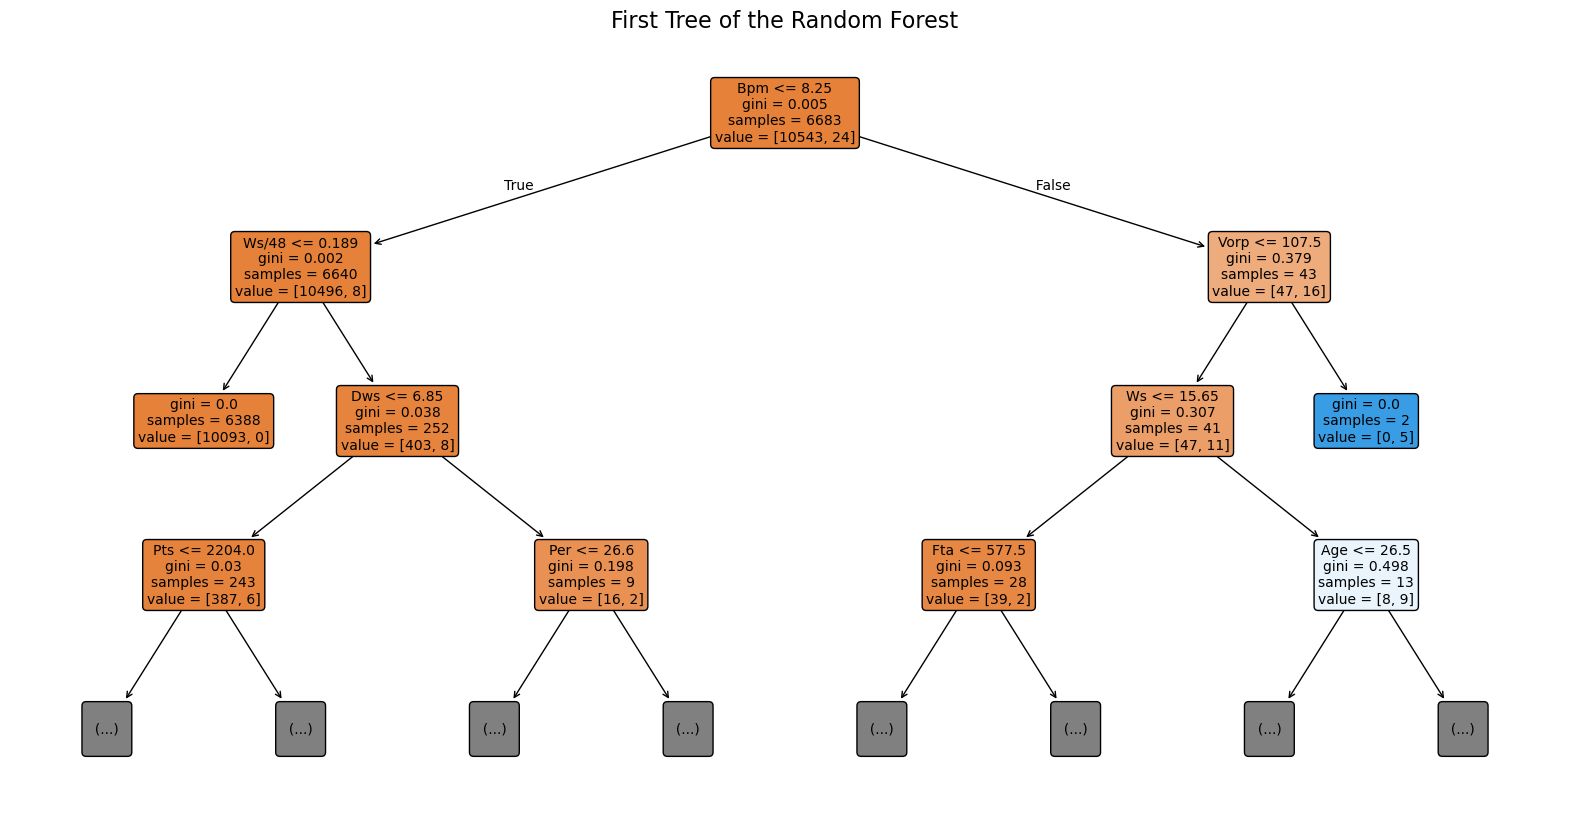

In [95]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


estimator = model_safe.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator, 
          feature_names=X_train_safe.columns,
          filled=True, 
          rounded=True,
          max_depth=3,  
          fontsize=10)
plt.title("First Tree of the Random Forest", fontsize=16)
plt.show()

In [66]:
def analyze_prediction(player_name, year=2017):
    """Analyse la prédiction pour un joueur spécifique"""
    player_data = df[(df['Player'] == player_name) & (df['Year'] == year)]
    if len(player_data) == 0:
        print(f"Joueur {player_name} non trouvé pour {year}")
        return
    
    player_idx = player_data.index[0]
    if player_idx not in X_test_safe.index:
        print("player isnt is the test set")
        return
    
   
    proba = model_safe.predict_proba(X_test_safe.loc[[player_idx]])[0, 1]
    
    print(f"Analysis for {player_name} ({year}):")
    print(f"Proba MVP: {proba:.1%}")
    
  
    feature_contributions = pd.DataFrame({
        'feature': X_train_safe.columns,
        'contribution': model_safe.feature_importances_
    }).sort_values('contribution', ascending=False)
    
    print(f"\n Top 5 features influentes:")
    print(feature_contributions.head(5))


analyze_prediction("Russell Westbrook", 2017)

Analyse pour Russell Westbrook (2017):
Proba MVP: 24.0%

 Top 5 features influentes:
               feature  contribution
42                   W      0.080267
17                  Ws      0.079699
43  Wins_Vs_League_Avg      0.051542
22                Vorp      0.051136
15                 Ows      0.040466


Full Forest: 100 trees
Sample of 5 trees


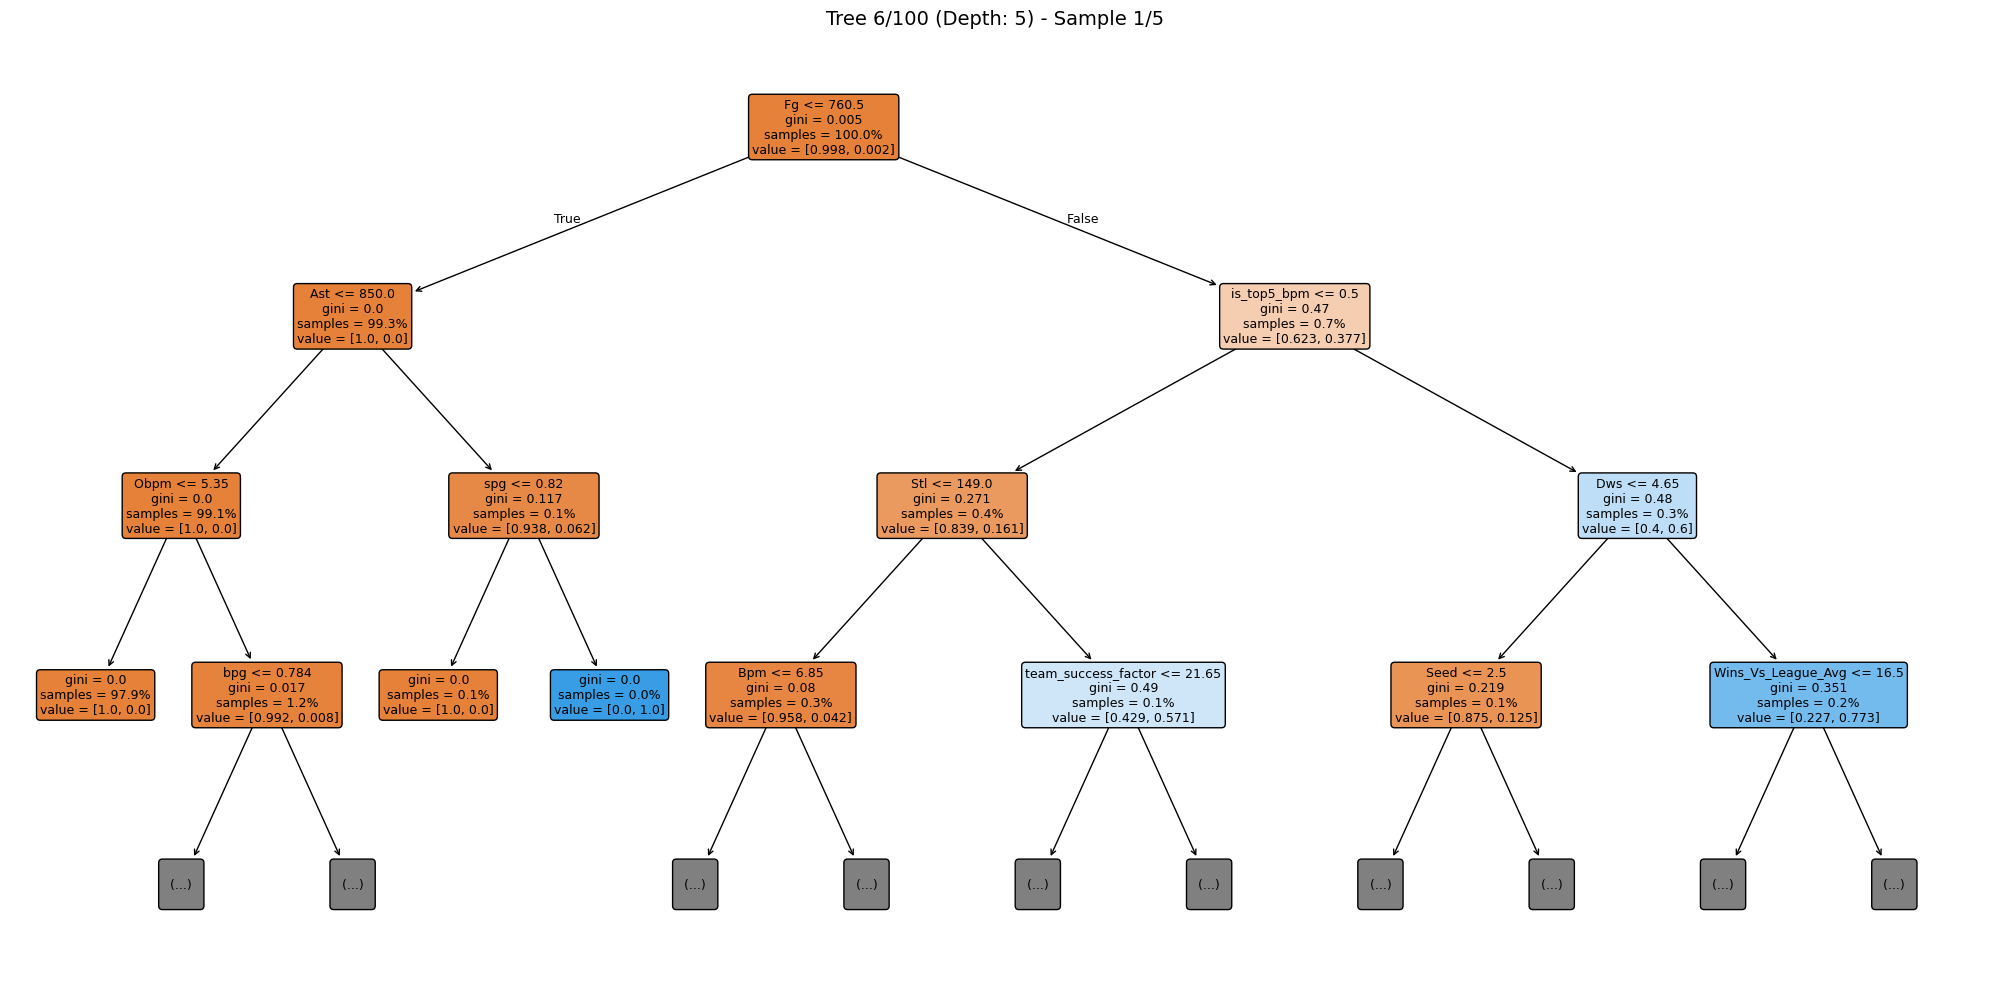

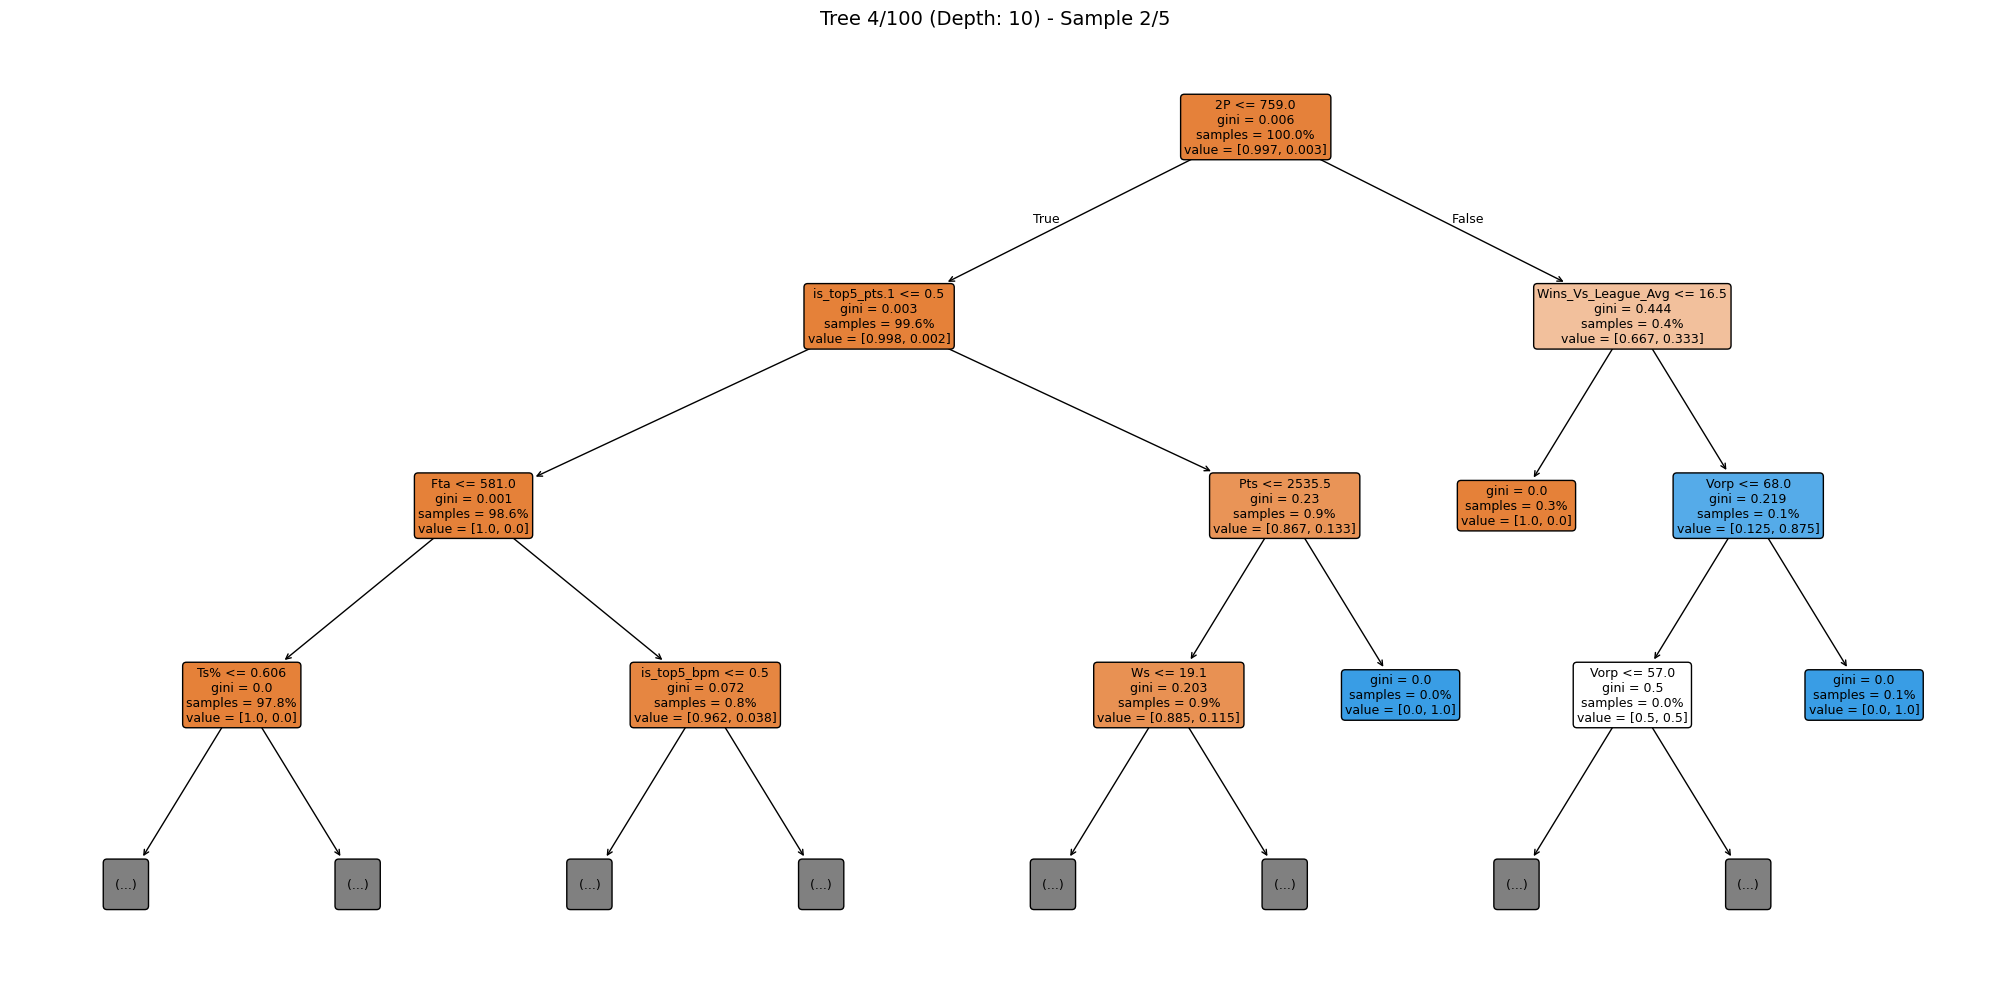

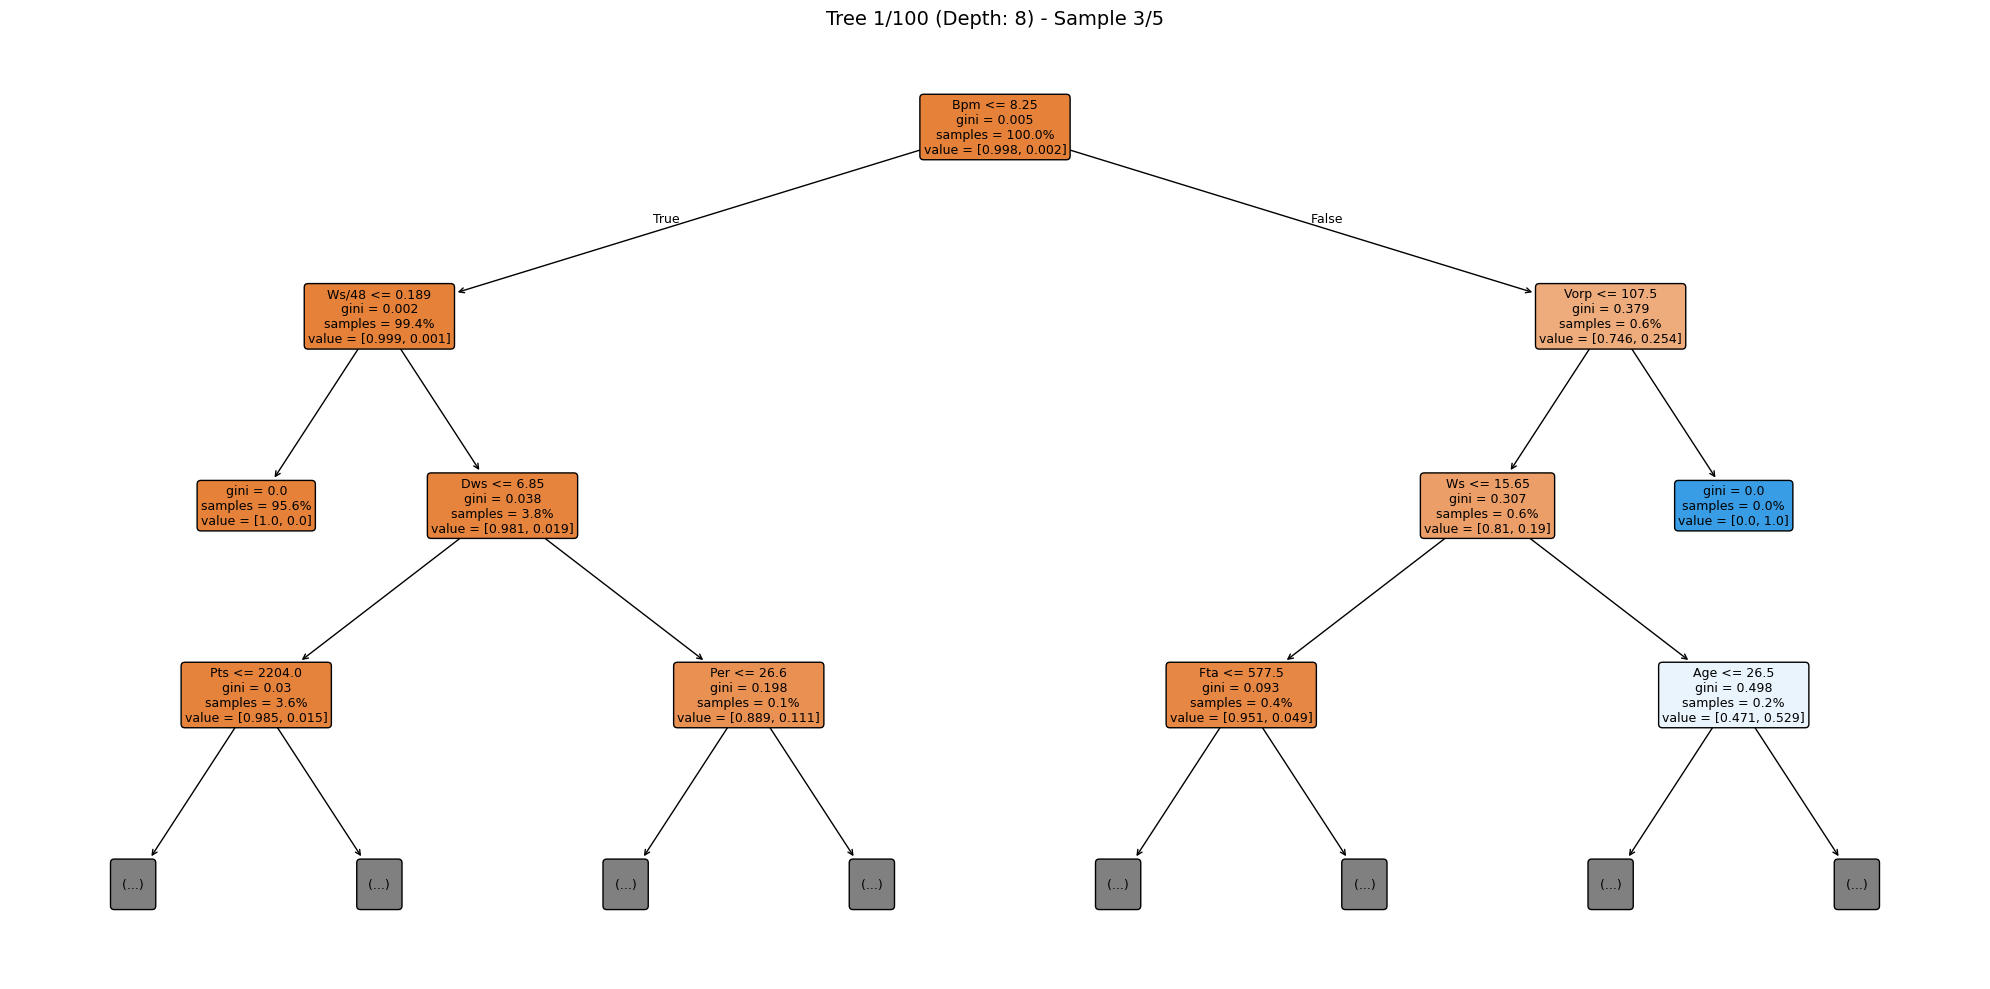

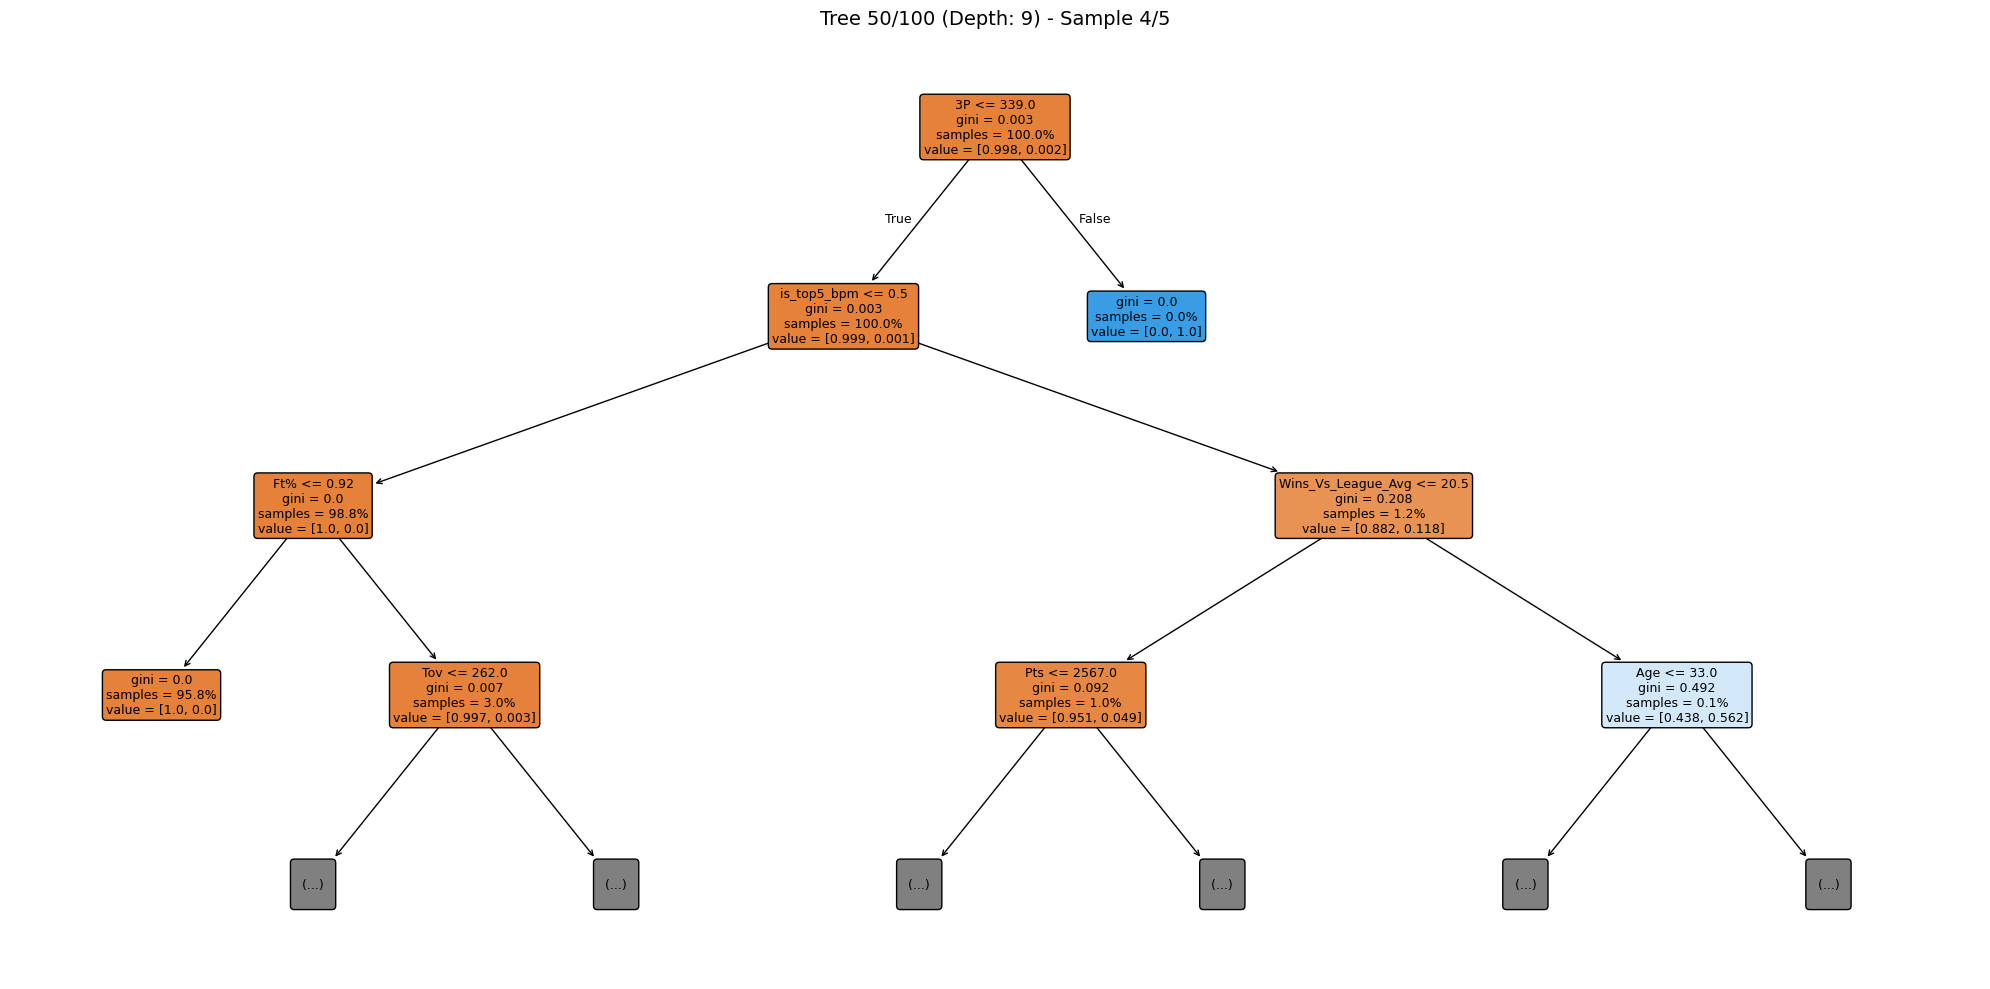

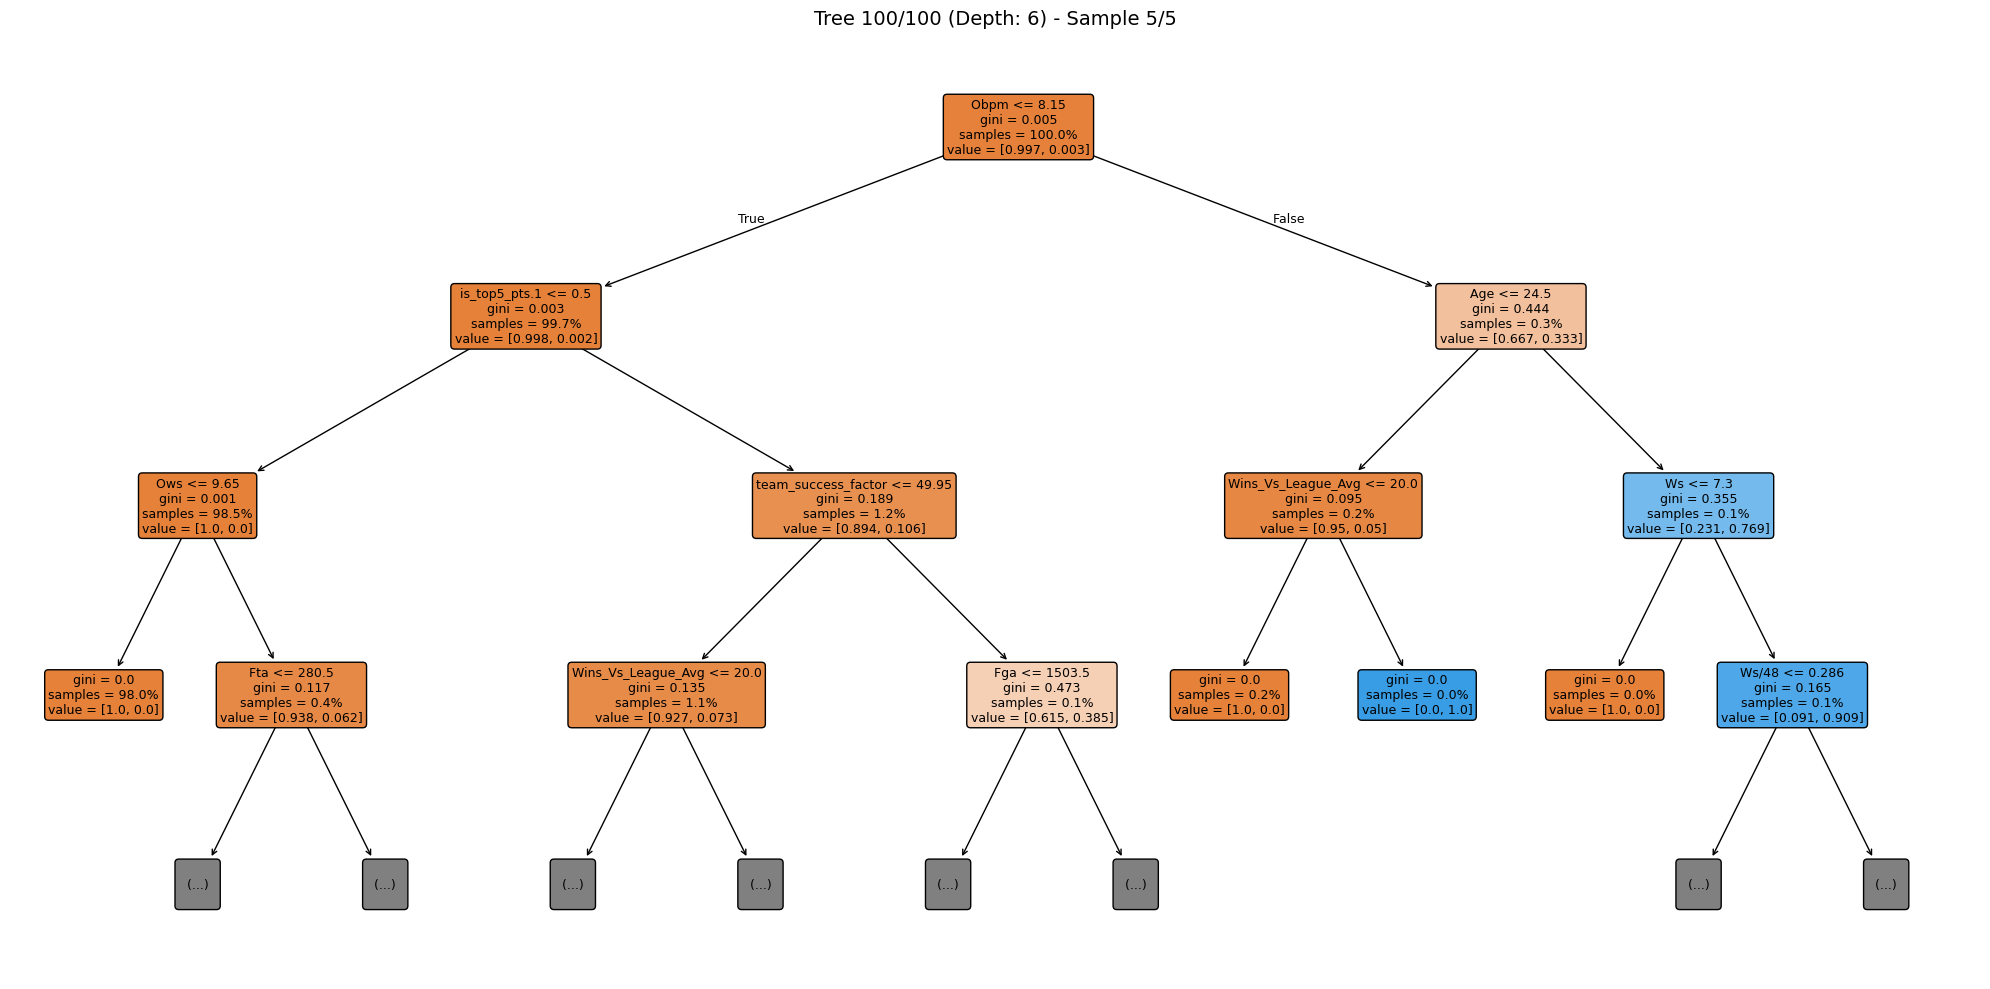

In [96]:
def display_forest_sample(model, feature_names, sample_size=5):
   
    n_trees = len(model.estimators_)
    print(f"Full Forest: {n_trees} trees")
    print(f"Sample of {sample_size} trees")
    
   
    depths = [tree.tree_.max_depth for tree in model.estimators_]
    indices = []
    
   
    indices.append(np.argmin(depths))  
    indices.append(np.argmax(depths))  
    indices.extend(np.linspace(0, n_trees-1, sample_size-2, dtype=int))  
    
    for i, idx in enumerate(indices[:sample_size]):
        tree = model.estimators_[idx]
        
        plt.figure(figsize=(20, 10))
        plot_tree(tree,
                  feature_names=feature_names,
                  filled=True,
                  rounded=True,
                  max_depth=3,
                  fontsize=9,
                  proportion=True)
        
        plt.title(f"Tree {idx+1}/{n_trees} (Depth: {depths[idx]}) - Sample {i+1}/{sample_size}", 
                 fontsize=14)
        plt.tight_layout()
        plt.show()

display_forest_sample(model_safe, X_train_safe.columns, sample_size=5)